In [1]:
from prov.model import ProvDocument, Namespace, Literal, PROV, Identifier
import datetime
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import GPUtil
import psutil
import cpuinfo
import platform
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score, mean_absolute_error, mean_squared_error 
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import tqdm
from tqdm import trange
import datetime
from datetime import date
import time
from pytorch_model_summary import hierarchical_summary
import json
import ipywidgets as widgets
import webbrowser
import IPython
from IPython.display import display, Image
import prov
from prov.model import ProvDocument
from prov.dot import prov_to_dot
import os


In [2]:


def primer_example():
    # https://github.com/lucmoreau/ProvToolbox/blob/master/prov-n/src/test/resources/prov/primer.pn
    # ===========================================================================
    # document
    g = ProvDocument()

    #    prefix ex <http://example/>
    #    prefix dcterms <http://purl.org/dc/terms/>
    #    prefix foaf <http://xmlns.com/foaf/0.1/>
    ex = Namespace(
        "ex", "http://example/"
    )  # namespaces do not need to be explicitly added to a document
    g.add_namespace("dcterms", "http://purl.org/dc/terms/")
    g.add_namespace("foaf", "http://xmlns.com/foaf/0.1/")

    #    entity(ex:article, [dcterms:title="Crime rises in cities"])
    # first time the ex namespace was used, it is added to the document automatically
    g.entity(ex["article"], {"dcterms:title": "Crime rises in cities"})
    #    entity(ex:articleV1)
    g.entity(ex["articleV1"])
    #    entity(ex:articleV2)
    g.entity(ex["articleV2"])
    #    entity(ex:dataSet1)
    g.entity(ex["dataSet1"])
    #    entity(ex:dataSet2)
    g.entity(ex["dataSet2"])
    #    entity(ex:regionList)
    g.entity(ex["regionList"])
    #    entity(ex:composition)
    g.entity(ex["composition"])
    #    entity(ex:chart1)
    g.entity(ex["chart1"])
    #    entity(ex:chart2)
    g.entity(ex["chart2"])
    #    entity(ex:blogEntry)
    g.entity(ex["blogEntry"])

    #    activity(ex:compile)
    g.activity("ex:compile")  # since ex is registered, it can be used like this
    #    activity(ex:compile2)
    g.activity("ex:compile2")
    #    activity(ex:compose)
    g.activity("ex:compose")
    #    activity(ex:correct, 2012-03-31T09:21:00, 2012-04-01T15:21:00)
    g.activity(
        "ex:correct", "2012-03-31T09:21:00", "2012-04-01T15:21:00"
    )  # date time can be provided as strings
    #    activity(ex:illustrate)
    g.activity("ex:illustrate")

    #    used(ex:compose, ex:dataSet1, -,   [ prov:role = "ex:dataToCompose"])
    g.used(
        "ex:compose", "ex:dataSet1", other_attributes={"prov:role": "ex:dataToCompose"}
    )
    #    used(ex:compose, ex:regionList, -, [ prov:role = "ex:regionsToAggregateBy"])
    g.used(
        "ex:compose",
        "ex:regionList",
        other_attributes={"prov:role": "ex:regionsToAggregateBy"},
    )
    #    wasGeneratedBy(ex:composition, ex:compose, -)
    g.wasGeneratedBy("ex:composition", "ex:compose")

    #    used(ex:illustrate, ex:composition, -)
    g.used("ex:illustrate", "ex:composition")
    #    wasGeneratedBy(ex:chart1, ex:illustrate, -)
    g.wasGeneratedBy("ex:chart1", "ex:illustrate")

    #    wasGeneratedBy(ex:chart1, ex:compile,  2012-03-02T10:30:00)
    g.wasGeneratedBy("ex:chart1", "ex:compile", "2012-03-02T10:30:00")
    #    wasGeneratedBy(ex:chart2, ex:compile2, 2012-04-01T15:21:00)
    #
    #
    #    agent(ex:derek, [ prov:type="prov:Person", foaf:givenName = "Derek",
    #           foaf:mbox= "<mailto:derek@example.org>"])
    g.agent(
        "ex:derek",
        {
            "prov:type": PROV["Person"],
            "foaf:givenName": "Derek",
            "foaf:mbox": "<mailto:derek@example.org>",
        },
    )
    #    wasAssociatedWith(ex:compose, ex:derek, -)
    g.wasAssociatedWith("ex:compose", "ex:derek")
    #    wasAssociatedWith(ex:illustrate, ex:derek, -)
    g.wasAssociatedWith("ex:illustrate", "ex:derek")
    #
    #    agent(ex:chartgen, [ prov:type="prov:Organization",
    #           foaf:name = "Chart Generators Inc"])
    g.agent(
        "ex:chartgen",
        {"prov:type": PROV["Organization"], "foaf:name": "Chart Generators Inc"},
    )
    #    actedOnBehalfOf(ex:derek, ex:chartgen, ex:compose)
    g.actedOnBehalfOf("ex:derek", "ex:chartgen", "ex:compose")
    #    wasAttributedTo(ex:chart1, ex:derek)
    g.wasAttributedTo("ex:chart1", "ex:derek")

    #    wasGeneratedBy(ex:dataSet2, ex:correct, -)
    g.wasGeneratedBy("ex:dataSet2", "ex:correct")
    #    used(ex:correct, ex:dataSet1, -)
    g.used("ex:correct", "ex:dataSet1")
    #    wasDerivedFrom(ex:dataSet2, ex:dataSet1, [prov:type='prov:Revision'])
    g.wasDerivedFrom(
        "ex:dataSet2", "ex:dataSet1", other_attributes={"prov:type": PROV["Revision"]}
    )
    #    wasDerivedFrom(ex:chart2, ex:dataSet2)
    g.wasDerivedFrom("ex:chart2", "ex:dataSet2")

    #    wasDerivedFrom(ex:blogEntry, ex:article, [prov:type='prov:Quotation'])
    g.wasDerivedFrom(
        "ex:blogEntry", "ex:article", other_attributes={"prov:type": PROV["Quotation"]}
    )
    #    specializationOf(ex:articleV1, ex:article)
    g.specializationOf("ex:articleV1", "ex:article")
    #    wasDerivedFrom(ex:articleV1, ex:dataSet1)
    g.wasDerivedFrom("ex:articleV1", "ex:dataSet1")

    #    specializationOf(ex:articleV2, ex:article)
    g.specializationOf("ex:articleV2", "ex:article")
    #    wasDerivedFrom(ex:articleV2, ex:dataSet2)
    g.wasDerivedFrom("ex:articleV2", "ex:dataSet2")

    #    alternateOf(ex:articleV2, ex:articleV1)
    g.alternateOf("ex:articleV2", "ex:articleV1")

    # endDocument
    return g


def primer_example_alternate():
    g = ProvDocument(
        namespaces={
            "ex": "http://example/",
            "dcterms": "http://purl.org/dc/terms/",
            "foaf": "http://xmlns.com/foaf/0.1/",
        }
    )

    article = g.entity("ex:article", {"dcterms:title": "Crime rises in cities"})
    articleV1 = g.entity("ex:articleV1")
    articleV2 = g.entity("ex:articleV2")
    dataSet1 = g.entity("ex:dataSet1")
    dataSet2 = g.entity("ex:dataSet2")
    regionList = g.entity("ex:regionList")
    composition = g.entity("ex:composition")
    chart1 = g.entity("ex:chart1")
    chart2 = g.entity("ex:chart2")
    blogEntry = g.entity("ex:blogEntry")

    compile = g.activity("ex:compile")
    compile2 = g.activity("ex:compile2")
    compose = g.activity("ex:compose")
    correct = g.activity("ex:correct", "2012-03-31T09:21:00", "2012-04-01T15:21:00")
    illustrate = g.activity("ex:illustrate")

    compose.used(dataSet1, attributes={"prov:role": "ex:dataToCompose"})
    compose.used(regionList, attributes={"prov:role": "ex:regionsToAggregateBy"})
    composition.wasGeneratedBy(compose)

    illustrate.used(composition)
    chart1.wasGeneratedBy(illustrate)

    chart1.wasGeneratedBy(compile, "2012-03-02T10:30:00")

    derek = g.agent(
        "ex:derek",
        {
            "prov:type": PROV["Person"],
            "foaf:givenName": "Derek",
            "foaf:mbox": "<mailto:derek@example.org>",
        },
    )
    compose.wasAssociatedWith(derek)
    illustrate.wasAssociatedWith(derek)

    chartgen = g.agent(
        "ex:chartgen",
        {"prov:type": PROV["Organization"], "foaf:name": "Chart Generators Inc"},
    )
    derek.actedOnBehalfOf(chartgen, compose)
    chart1.wasAttributedTo(derek)

    dataSet2.wasGeneratedBy(correct)
    correct.used(dataSet1)
    dataSet2.wasDerivedFrom(dataSet1, attributes={"prov:type": PROV["Revision"]})
    chart2.wasDerivedFrom(dataSet2)

    blogEntry.wasDerivedFrom(article, attributes={"prov:type": PROV["Quotation"]})
    articleV1.specializationOf(article)
    articleV1.wasDerivedFrom(dataSet1)

    articleV2.specializationOf(article)
    articleV2.wasDerivedFrom(dataSet2)

    articleV2.alternateOf(articleV1)

    return g


def w3c_publication_1():
    # https://github.com/lucmoreau/ProvToolbox/blob/master/asn/src/test/resources/prov/w3c-publication1.prov-asn
    # ===========================================================================
    # bundle
    #
    # prefix ex  <http://example.org/>
    #
    # prefix w3      <http://www.w3.org/>
    # prefix tr      <http://www.w3.org/TR/2011/>
    # prefix process <http://www.w3.org/2005/10/Process-20051014/tr.html#>
    # prefix email   <https://lists.w3.org/Archives/Member/w3c-archive/>
    # prefix chairs  <https://lists.w3.org/Archives/Member/chairs/>
    # prefix trans   <http://www.w3.org/2005/08/01-transitions.html#>
    # prefix rec54   <http://www.w3.org/2001/02pd/rec54#>
    #
    #
    #  entity(tr:WD-prov-dm-20111018, [ prov:type='rec54:WD' ])
    #  entity(tr:WD-prov-dm-20111215, [ prov:type='rec54:WD' ])
    #  entity(process:rec-advance,    [ prov:type='prov:Plan' ])
    #
    #
    #  entity(chairs:2011OctDec/0004, [ prov:type='trans:transreq' ])
    #  entity(email:2011Oct/0141,     [ prov:type='trans:pubreq' ])
    #  entity(email:2011Dec/0111,     [ prov:type='trans:pubreq' ])
    #
    #
    #  wasDerivedFrom(tr:WD-prov-dm-20111215, tr:WD-prov-dm-20111018)
    #
    #
    #  activity(ex:act1,-,-,[prov:type="publish"])
    #  activity(ex:act2,-,-,[prov:type="publish"])
    #
    #  wasGeneratedBy(tr:WD-prov-dm-20111018, ex:act1, -)
    #  wasGeneratedBy(tr:WD-prov-dm-20111215, ex:act2, -)
    #
    #  used(ex:act1, chairs:2011OctDec/0004, -)
    #  used(ex:act1, email:2011Oct/0141, -)
    #  used(ex:act2, email:2011Dec/0111, -)
    #
    #  agent(w3:Consortium, [ prov:type='prov:Organization' ])
    #
    #  wasAssociatedWith(ex:act1, w3:Consortium, process:rec-advance)
    #  wasAssociatedWith(ex:act2, w3:Consortium, process:rec-advance)
    #
    # endBundle
    # ===========================================================================

    g = ProvDocument()
    g.add_namespace("ex", "http://example.org/")
    g.add_namespace("w3", "http://www.w3.org/")
    g.add_namespace("tr", "http://www.w3.org/TR/2011/")
    g.add_namespace("process", "http://www.w3.org/2005/10/Process-20051014/tr.html#")
    g.add_namespace("email", "https://lists.w3.org/Archives/Member/w3c-archive/")
    g.add_namespace("chairs", "https://lists.w3.org/Archives/Member/chairs/")
    g.add_namespace("trans", "http://www.w3.org/2005/08/01-transitions.html#")
    g.add_namespace("rec54", "http://www.w3.org/2001/02pd/rec54#")

    g.entity("tr:WD-prov-dm-20111018", {"prov:type": "rec54:WD"})
    g.entity("tr:WD-prov-dm-20111215", {"prov:type": "rec54:WD"})
    g.entity("process:rec-advance", {"prov:type": "prov:Plan"})

    g.entity("chairs:2011OctDec/0004", {"prov:type": "trans:transreq"})
    g.entity("email:2011Oct/0141", {"prov:type": "trans:pubreq"})
    g.entity("email:2011Dec/0111", {"prov:type": "trans:pubreq"})

    g.wasDerivedFrom("tr:WD-prov-dm-20111215", "tr:WD-prov-dm-20111018")

    g.activity("ex:act1", other_attributes={"prov:type": "publish"})
    g.activity("ex:act2", other_attributes={"prov:type": "publish"})

    g.wasGeneratedBy("tr:WD-prov-dm-20111018", "ex:act1")
    g.wasGeneratedBy("tr:WD-prov-dm-20111215", "ex:act2")

    g.used("ex:act1", "chairs:2011OctDec/0004")
    g.used("ex:act1", "email:2011Oct/0141")
    g.used("ex:act2", "email:2011Dec/0111")

    g.agent("w3:Consortium", other_attributes={"prov:type": "Organization"})

    g.wasAssociatedWith("ex:act1", "w3:Consortium", "process:rec-advance")
    g.wasAssociatedWith("ex:act2", "w3:Consortium", "process:rec-advance")

    return g


def w3c_publication_2():
    # https://github.com/lucmoreau/ProvToolbox/blob/master/asn/src/test/resources/prov/w3c-publication2.prov-asn
    # ===========================================================================
    # bundle
    #
    # prefix ex <http://example.org/>
    # prefix rec <http://example.org/record>
    #
    # prefix w3 <http://www.w3.org/TR/2011/>
    # prefix hg <http://dvcs.w3.org/hg/prov/raw-file/9628aaff6e20/model/releases/WD-prov-dm-20111215/>
    #
    #
    # entity(hg:Overview.html, [ prov:type="file in hg" ])
    # entity(w3:WD-prov-dm-20111215, [ prov:type="html4" ])
    #
    #
    # activity(ex:rcp,-,-,[prov:type="copy directory"])
    #
    # wasGeneratedBy(rec:g; w3:WD-prov-dm-20111215, ex:rcp, -)
    #
    # entity(ex:req3, [ prov:type="http://www.w3.org/2005/08/01-transitions.html#pubreq" %% xsd:anyURI ])
    #
    # used(rec:u; ex:rcp,hg:Overview.html,-)
    # used(ex:rcp, ex:req3, -)
    #
    #
    # wasDerivedFrom(w3:WD-prov-dm-20111215, hg:Overview.html, ex:rcp, rec:g, rec:u)
    #
    # agent(ex:webmaster, [ prov:type='prov:Person' ])
    #
    # wasAssociatedWith(ex:rcp, ex:webmaster, -)
    #
    # endBundle
    # ===========================================================================

    ex = Namespace("ex", "http://example.org/")
    rec = Namespace("rec", "http://example.org/record")
    w3 = Namespace("w3", "http://www.w3.org/TR/2011/")
    hg = Namespace(
        "hg",
        "http://dvcs.w3.org/hg/prov/raw-file/9628aaff6e20/model/releases/WD-prov-dm-20111215/",
    )

    g = ProvDocument()

    g.entity(hg["Overview.html"], {"prov:type": "file in hg"})
    g.entity(w3["WD-prov-dm-20111215"], {"prov:type": "html4"})

    g.activity(ex["rcp"], None, None, {"prov:type": "copy directory"})

    g.wasGeneratedBy("w3:WD-prov-dm-20111215", "ex:rcp", identifier=rec["g"])

    g.entity(
        "ex:req3",
        {
            "prov:type": Identifier(
                "http://www.w3.org/2005/08/01-transitions.html#pubreq"
            )
        },
    )

    g.used("ex:rcp", "hg:Overview.html", identifier="rec:u")
    g.used("ex:rcp", "ex:req3")

    g.wasDerivedFrom(
        "w3:WD-prov-dm-20111215", "hg:Overview.html", "ex:rcp", "rec:g", "rec:u"
    )

    g.agent("ex:webmaster", {"prov:type": "Person"})

    g.wasAssociatedWith("ex:rcp", "ex:webmaster")

    return g


def bundles1():
    # https://github.com/lucmoreau/ProvToolbox/blob/master/prov-n/src/test/resources/prov/bundles1.provn
    # ===============================================================================
    # document
    g = ProvDocument()

    #   prefix ex  <http://example.org/example/>
    EX = Namespace("ex", "http://www.example.com/")
    g.add_namespace(EX)

    #   prefix alice  <http://example.org/alice/>
    #   prefix bob  <http://example.org/bob/>
    g.add_namespace("alice", "http://example.org/alice/")
    g.add_namespace("bob", "http://example.org/bob/")

    #   entity(bob:bundle1, [prov:type='prov:Bundle'])
    g.entity("bob:bundle1", {"prov:type": PROV["Bundle"]})
    #   wasGeneratedBy(bob:bundle1, -, 2012-05-24T10:30:00)
    g.wasGeneratedBy("bob:bundle1", time="2012-05-24T10:30:00")
    #   agent(ex:Bob)
    g.agent("ex:Bob")
    #   wasAttributedTo(bob:bundle1, ex:Bob)
    g.wasAttributedTo("bob:bundle1", "ex:Bob")

    #   entity(alice:bundle2, [ prov:type='prov:Bundle' ])
    g.entity("alice:bundle2", {"prov:type": PROV["Bundle"]})
    #   wasGeneratedBy(alice:bundle2, -, 2012-05-25T11:15:00)
    g.wasGeneratedBy("alice:bundle2", time="2012-05-25T11:15:00")
    #   agent(ex:Alice)
    g.agent("ex:Alice")
    #   wasAttributedTo(alice:bundle2, ex:Alice)
    g.wasAttributedTo("alice:bundle2", "ex:Alice")

    #   bundle bob:bundle1
    b1 = g.bundle("bob:bundle1")
    #     entity(ex:report1, [ prov:type="report", ex:version=1 ])
    b1.entity("ex:report1", {"prov:type": "report", "ex:version": 1})
    #     wasGeneratedBy(ex:report1, -, 2012-05-24T10:00:01)
    b1.wasGeneratedBy("ex:report1", time="2012-05-24T10:00:01")
    #   endBundle

    #   bundle alice:bundle2
    b2 = g.bundle("alice:bundle2")
    #     entity(ex:report1)
    b2.entity("ex:report1")
    #     entity(ex:report2, [ prov:type="report", ex:version=2 ])
    b2.entity("ex:report2", {"prov:type": "report", "ex:version": 2})
    #     wasGeneratedBy(ex:report2, -, 2012-05-25T11:00:01)
    b2.wasGeneratedBy("ex:report2", time="2012-05-25T11:00:01")
    #     wasDerivedFrom(ex:report2, ex:report1)
    b2.wasDerivedFrom("ex:report2", "ex:report1")
    #   endBundle

    # endDocument
    return g


def bundles2():
    # https://github.com/lucmoreau/ProvToolbox/blob/master/prov-n/src/test/resources/prov/bundles2.provn
    # ===========================================================================
    # document
    g = ProvDocument()

    #   prefix ex  <http://example.org/example/>
    g.add_namespace("ex", "http://www.example.com/")

    #   prefix alice  <http://example.org/alice/>
    #   prefix bob  <http://example.org/bob/>
    g.add_namespace("alice", "http://example.org/alice/")
    g.add_namespace("bob", "http://example.org/bob/")

    #   entity(bob:bundle4, [prov:type='prov:Bundle'])
    #   wasGeneratedBy(bob:bundle4, -, 2012-05-24T10:30:00)
    #   agent(ex:Bob)
    #   wasAttributedTo(bob:bundle4, ex:Bob)
    g.entity("bob:bundle4", {"prov:type": PROV["Bundle"]})
    g.wasGeneratedBy("bob:bundle4", time="2012-05-24T10:30:00")
    g.agent("ex:Bob")
    g.wasAttributedTo("bob:bundle4", "ex:Bob")

    #   entity(alice:bundle5, [ prov:type='prov:Bundle' ])
    #   wasGeneratedBy(alice:bundle5, -, 2012-05-25T11:15:00)
    #   agent(ex:Alice)
    #   wasAttributedTo(alice:bundle5, ex:Alice)
    g.entity("alice:bundle5", {"prov:type": PROV["Bundle"]})
    g.wasGeneratedBy("alice:bundle5", time="2012-05-25T11:15:00")
    g.agent("ex:Alice")
    g.wasAttributedTo("alice:bundle5", "ex:Alice")

    #   bundle bob:bundle4
    #     entity(ex:report1, [ prov:type="report", ex:version=1 ])
    #     wasGeneratedBy(ex:report1, -, 2012-05-24T10:00:01)
    #   endBundle
    b4 = g.bundle("bob:bundle4")
    b4.entity("ex:report1", {"prov:type": "report", "ex:version": 1})
    b4.wasGeneratedBy("ex:report1", time="2012-05-24T10:00:01")

    #   bundle alice:bundle5
    #     entity(ex:report1bis)
    #     mentionOf(ex:report1bis, ex:report1, bob:bundle4)
    #     entity(ex:report2, [ prov:type="report", ex:version=2 ])
    #     wasGeneratedBy(ex:report2, -, 2012-05-25T11:00:01)
    #     wasDerivedFrom(ex:report2, ex:report1bis)
    #   endBundle
    b5 = g.bundle("alice:bundle5")
    b5.entity("ex:report1bis")
    b5.mentionOf("ex:report1bis", "ex:report1", "bob:bundle4")
    b5.entity("ex:report2", [("prov:type", "report"), ("ex:version", 2)])
    b5.wasGeneratedBy("ex:report2", time="2012-05-25T11:00:01")
    b5.wasDerivedFrom("ex:report2", "ex:report1bis")

    # endDocument
    return g


def collections():
    g = ProvDocument()
    ex = Namespace("ex", "http://example.org/")

    c1 = g.collection(ex["c1"])
    e1 = g.entity("ex:e1")
    g.hadMember(c1, e1)

    return g


def datatypes():
    g = ProvDocument()
    ex = Namespace("ex", "http://example.org/")
    g.add_namespace(ex)

    attributes = {
        "ex:int": 100,
        "ex:float": 100.123456,
        "ex:long": 123456789000,
        "ex:bool": True,
        "ex:str": "Some string",
        "ex:unicode": "Some unicode string with accents: Huỳnh Trung Đông",
        "ex:timedate": datetime.datetime(2012, 12, 12, 14, 7, 48),
        "ex:intstr": Literal(
            "PROV Internationalized string", PROV["InternationalizedString"], "en"
        ),
    }
    multiline = """Line1
    Line2
Line3"""
    attributes["ex:multi-line"] = multiline
    g.entity("ex:e1", attributes)
    return g


def long_literals():
    g = ProvDocument()

    long_uri = (
        "http://Lorem.ipsum/dolor/sit/amet/consectetur/adipiscing/elit/Quisque/vel/sollicitudin/felis/nec/"
        "venenatis/massa/Aenean/lectus/arcu/sagittis/sit/amet/nisl/nec/varius/eleifend/sem/In/hac/habitasse/"
        "platea/dictumst/Aliquam/eget/fermentum/enim/Curabitur/auctor/elit/non/ipsum/interdum/at/orci/aliquam/"
    )
    ex = Namespace("ex", long_uri)
    g.add_namespace(ex)

    g.entity(
        "ex:e1",
        {
            "prov:label": "Lorem ipsum dolor sit amet, consectetur adipiscing elit. Donec pellentesque luctus nulla vel "
            "ullamcorper. Donec sit amet ligula sit amet lorem pretium rhoncus vel vel lorem. Sed at "
            "consequat metus, eget eleifend massa. Fusce a facilisis turpis. Lorem volutpat."
        },
    )

    return g


tests = [
    ("Bundle1", bundles1),
    ("Bundle2", bundles2),
    ("Primer", primer_example),
    ("W3C Publication 1", w3c_publication_1),
    ("W3C Publication 2", w3c_publication_2),
    ("collections", collections),
    ("datatypes", datatypes),
    ("Long literals", long_literals),
]

Button(description='Open Image File', style=ButtonStyle())

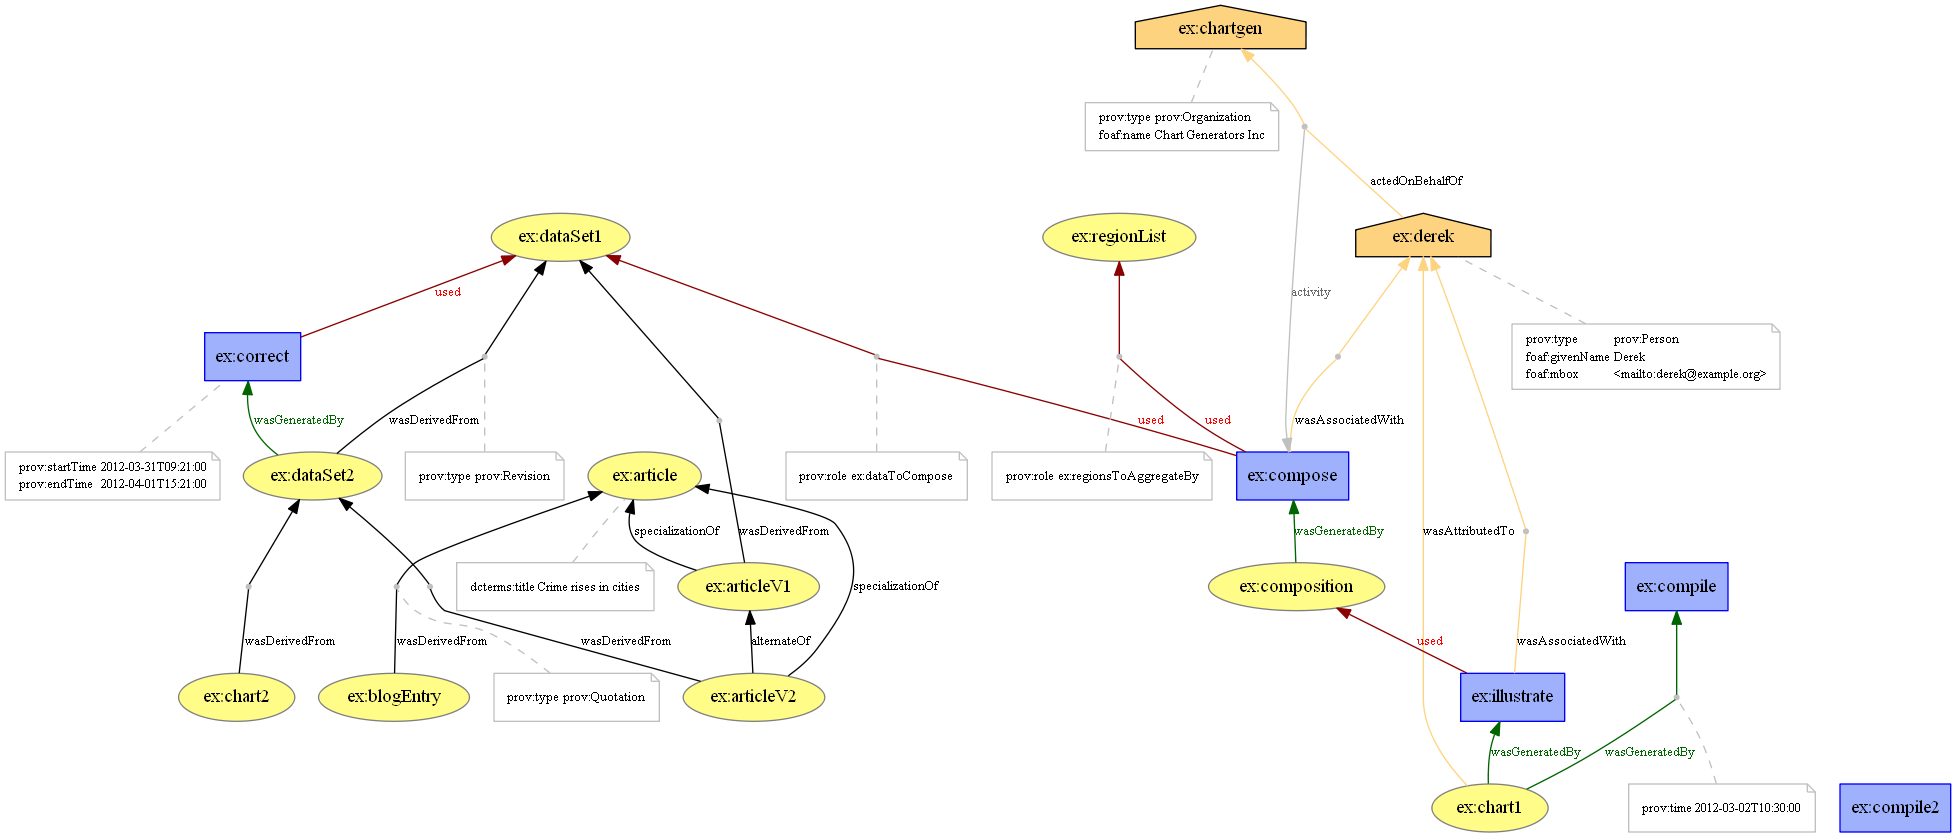

In [3]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

#get time for filenames
timestring = time.strftime('%Y%m%d-%H%M%S')
timestring
ProvenanceNameImage = ('Provenance_MulticlassClassification_' + timestring + '.png')

#dot = prov_to_dot(d1, direction='RL')


dot = prov_to_dot(primer_example())
dot.write_png('../GeneratedProvenanceData/'+ProvenanceNameImage)

provenanceImage_open = widgets.Button(description = 'Open Image File')
display(provenanceImage_open)

def on_button_clicked(b):
    provenanceImage_open.on_click = webbrowser.open('http://localhost:8888/lab/tree/GeneratedProvenanceData/'+ProvenanceNameImage)

provenanceImage_open.on_click(on_button_clicked)
Image('../GeneratedProvenanceData/'+ProvenanceNameImage)

Button(description='Open Image File', style=ButtonStyle())

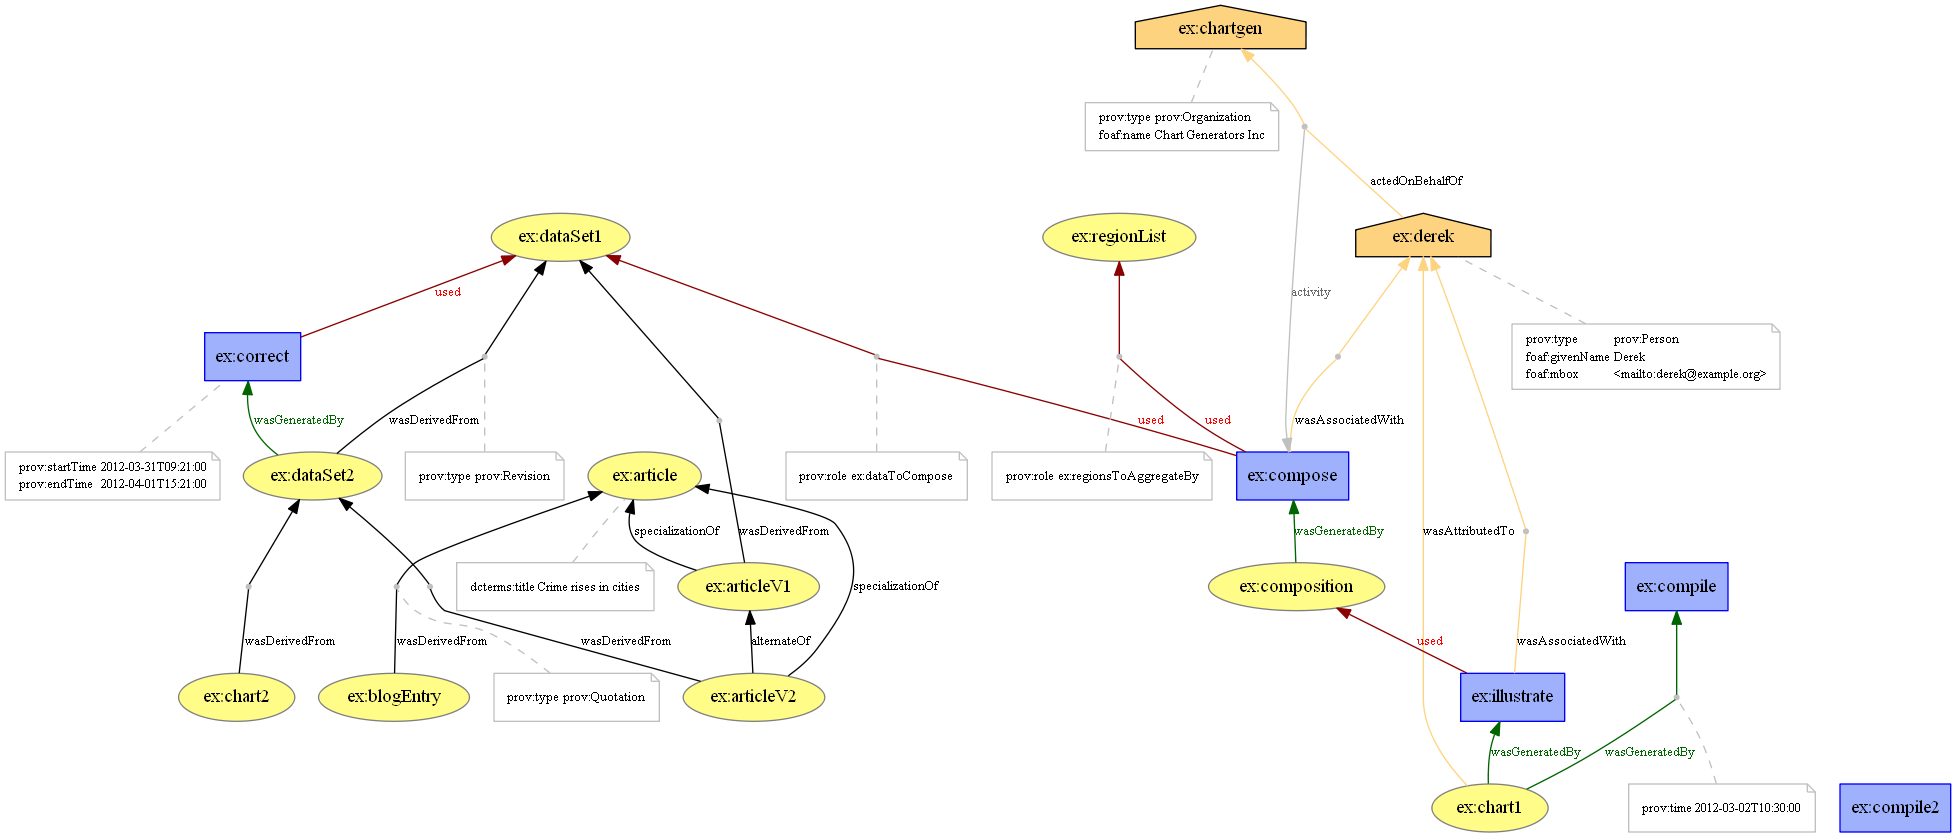

In [4]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

#get time for filenames
timestring = time.strftime('%Y%m%d-%H%M%S')
timestring
ProvenanceNameImage = ('Provenance_MulticlassClassification_' + timestring + '.png')

#dot = prov_to_dot(d1, direction='RL')


dot = prov_to_dot(primer_example_alternate())
dot.write_png('../GeneratedProvenanceData/'+ProvenanceNameImage)

provenanceImage_open = widgets.Button(description = 'Open Image File')
display(provenanceImage_open)

def on_button_clicked(b):
    provenanceImage_open.on_click = webbrowser.open('http://localhost:8888/lab/tree/GeneratedProvenanceData/'+ProvenanceNameImage)

provenanceImage_open.on_click(on_button_clicked)
Image('../GeneratedProvenanceData/'+ProvenanceNameImage)

Button(description='Open Image File', style=ButtonStyle())

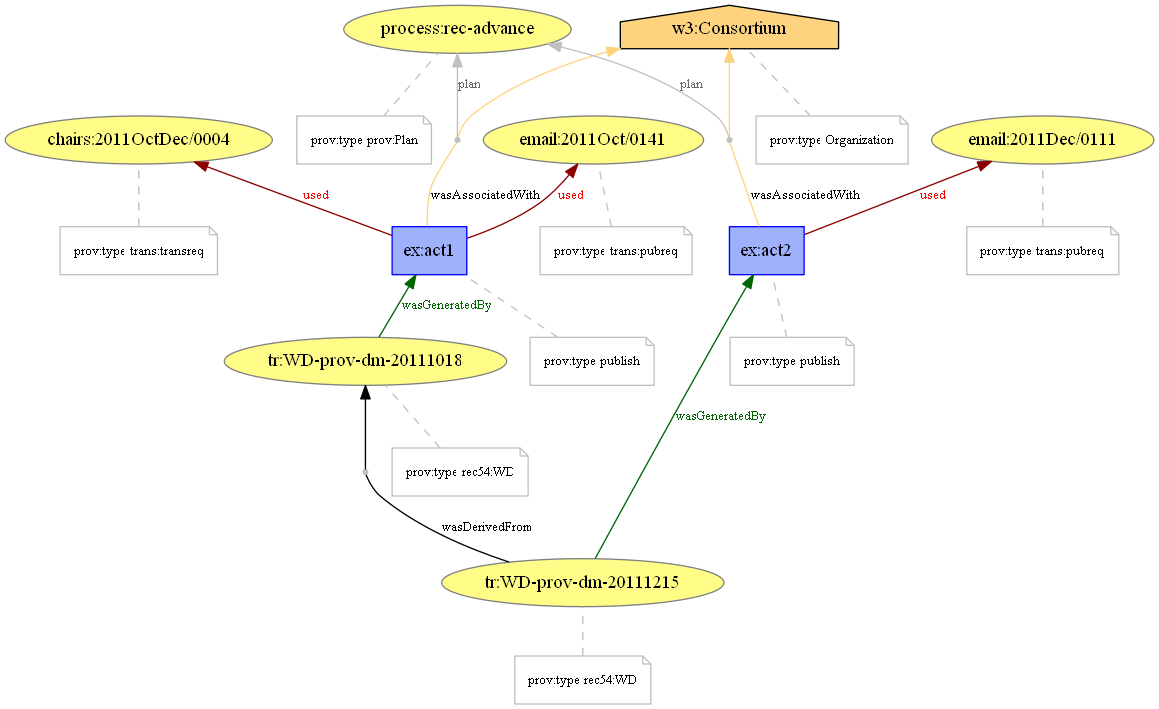

In [5]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

#get time for filenames
timestring = time.strftime('%Y%m%d-%H%M%S')
timestring
ProvenanceNameImage = ('Provenance_MulticlassClassification_' + timestring + '.png')

#dot = prov_to_dot(d1, direction='RL')


dot = prov_to_dot(w3c_publication_1())
dot.write_png('../GeneratedProvenanceData/'+ProvenanceNameImage)

provenanceImage_open = widgets.Button(description = 'Open Image File')
display(provenanceImage_open)

def on_button_clicked(b):
    provenanceImage_open.on_click = webbrowser.open('http://localhost:8888/lab/tree/GeneratedProvenanceData/'+ProvenanceNameImage)

provenanceImage_open.on_click(on_button_clicked)
Image('../GeneratedProvenanceData/'+ProvenanceNameImage)

Button(description='Open Image File', style=ButtonStyle())

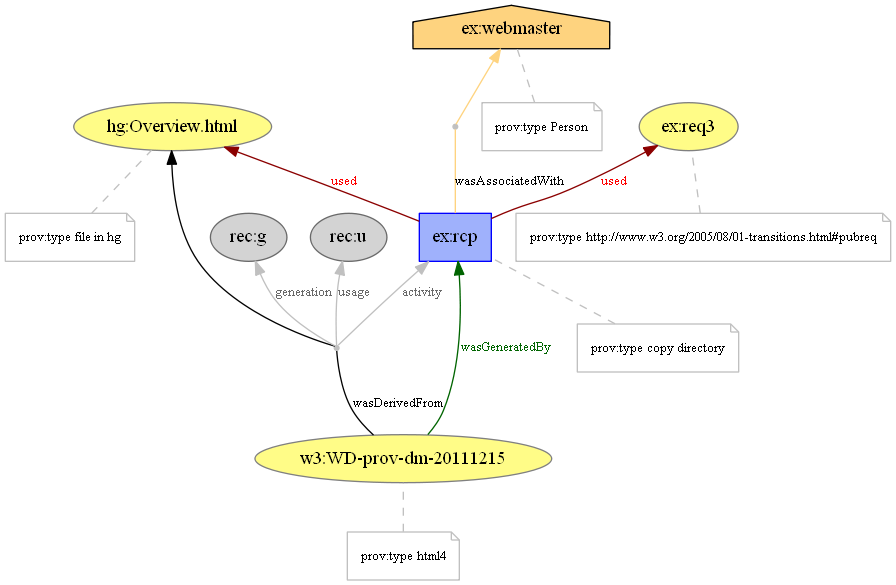

In [6]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

#get time for filenames
timestring = time.strftime('%Y%m%d-%H%M%S')
timestring
ProvenanceNameImage = ('Provenance_MulticlassClassification_' + timestring + '.png')

#dot = prov_to_dot(d1, direction='RL')


dot = prov_to_dot(w3c_publication_2())
dot.write_png('../GeneratedProvenanceData/'+ProvenanceNameImage)

provenanceImage_open = widgets.Button(description = 'Open Image File')
display(provenanceImage_open)

def on_button_clicked(b):
    provenanceImage_open.on_click = webbrowser.open('http://localhost:8888/lab/tree/GeneratedProvenanceData/'+ProvenanceNameImage)

provenanceImage_open.on_click(on_button_clicked)
Image('../GeneratedProvenanceData/'+ProvenanceNameImage)

Button(description='Open Image File', style=ButtonStyle())

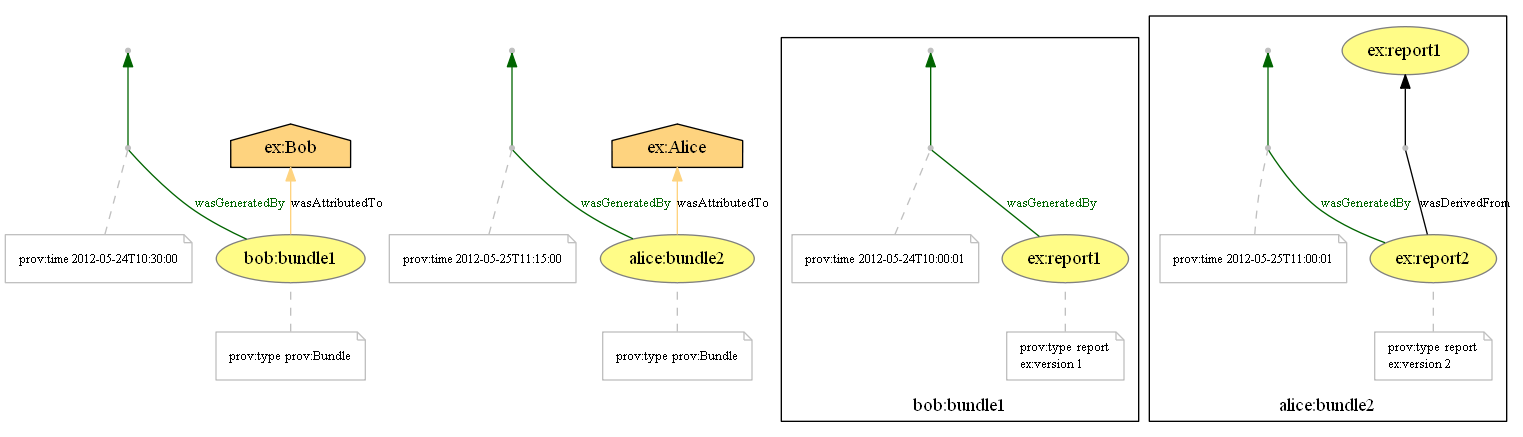

In [7]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

#get time for filenames
timestring = time.strftime('%Y%m%d-%H%M%S')
timestring
ProvenanceNameImage = ('Provenance_MulticlassClassification_' + timestring + '.png')

#dot = prov_to_dot(d1, direction='RL')


dot = prov_to_dot(bundles1())
dot.write_png('../GeneratedProvenanceData/'+ProvenanceNameImage)

provenanceImage_open = widgets.Button(description = 'Open Image File')
display(provenanceImage_open)

def on_button_clicked(b):
    provenanceImage_open.on_click = webbrowser.open('http://localhost:8888/lab/tree/GeneratedProvenanceData/'+ProvenanceNameImage)

provenanceImage_open.on_click(on_button_clicked)
Image('../GeneratedProvenanceData/'+ProvenanceNameImage)

Button(description='Open Image File', style=ButtonStyle())

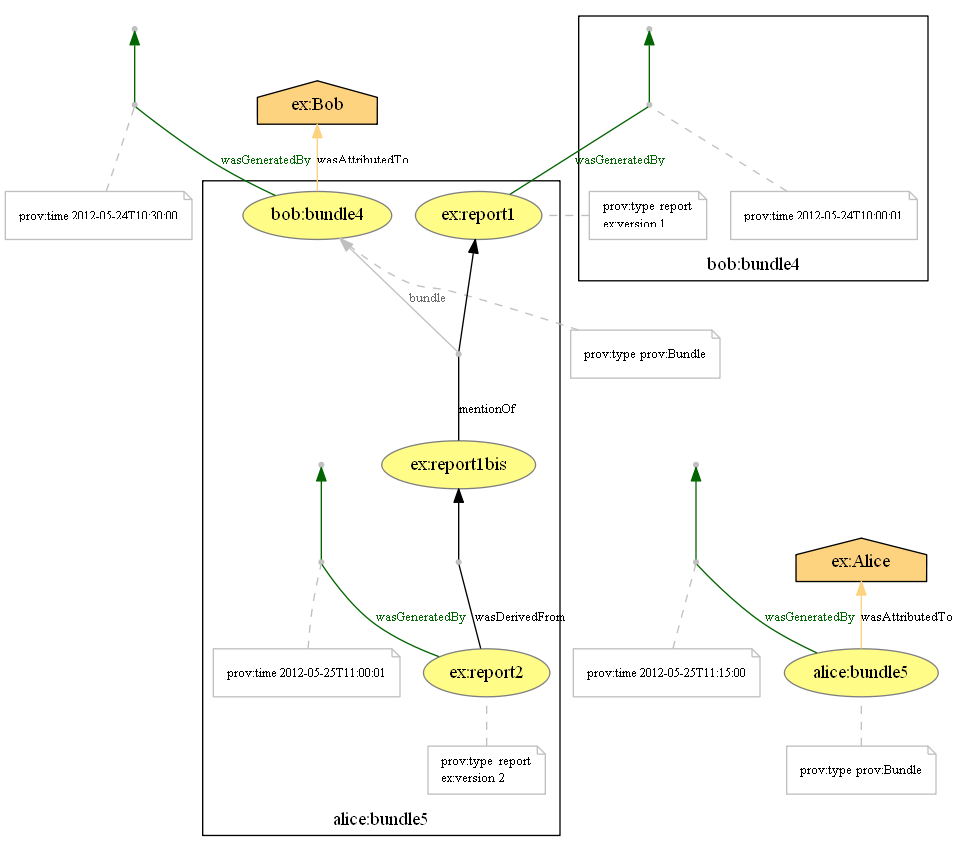

In [8]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

#get time for filenames
timestring = time.strftime('%Y%m%d-%H%M%S')
timestring
ProvenanceNameImage = ('Provenance_MulticlassClassification_' + timestring + '.png')

#dot = prov_to_dot(d1, direction='RL')


dot = prov_to_dot(bundles2())
dot.write_png('../GeneratedProvenanceData/'+ProvenanceNameImage)

provenanceImage_open = widgets.Button(description = 'Open Image File')
display(provenanceImage_open)

def on_button_clicked(b):
    provenanceImage_open.on_click = webbrowser.open('http://localhost:8888/lab/tree/GeneratedProvenanceData/'+ProvenanceNameImage)

provenanceImage_open.on_click(on_button_clicked)
Image('../GeneratedProvenanceData/'+ProvenanceNameImage)

Button(description='Open Image File', style=ButtonStyle())

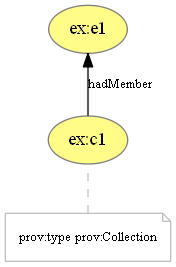

In [9]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

#get time for filenames
timestring = time.strftime('%Y%m%d-%H%M%S')
timestring
ProvenanceNameImage = ('Provenance_MulticlassClassification_' + timestring + '.png')

#dot = prov_to_dot(d1, direction='RL')


dot = prov_to_dot(collections())
dot.write_png('../GeneratedProvenanceData/'+ProvenanceNameImage)

provenanceImage_open = widgets.Button(description = 'Open Image File')
display(provenanceImage_open)

def on_button_clicked(b):
    provenanceImage_open.on_click = webbrowser.open('http://localhost:8888/lab/tree/GeneratedProvenanceData/'+ProvenanceNameImage)

provenanceImage_open.on_click(on_button_clicked)
Image('../GeneratedProvenanceData/'+ProvenanceNameImage)